## The Factors and Impacts on South Korea’s Fertility Decline: An Analysis of Social, Economic, and Demographic Impacts

##### SAS Hackathon 2023
Victor Ahn, Federico Chung, Sebin Lee, Yongjung Lee, Jangwon Yun


### Business Case
This research will focus on analyzing the factors that have influenced South Korea's extraordinary fertility decline. The birth rate in South Korea has dropped significantly over the past few decades, with significant social, economic, and demographic consequences. Our team will collect data from various sources, including government reports, demographic surveys, and academic studies, to better understand the underlying factors that have contributed to the fertility decline. Using data analysis and visualization tools, such as Python and SAS Viya, we will identify the key factors, such as changing social attitudes towards marriage and family, economic conditions, gender inequality, and healthcare concerns. That being said, this research will enable us to collaborate and develop new skills in data analysis and data science. We will work together to explore different approaches to analyzing the data and interpreting the results, in hopes to provide significant implications for policymakers seeking to address the declining birth rate in South Korea. This research hopes to demonstrate our ability to leverage data analytics to provide valuable insights into pressing social issues.

### Research Question
What factors have contributed the most to South Korea's fertility decline?

### Research Objectives
1. To determine the primary factors responsible for the decrease in fertility rates in South Korea.
2. To address what can be done to invalidate the top contributing factors to slow down the decline.


### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from yellowbrick.regressor import PredictionError, ResidualsPlot
from sklearn.preprocessing import StandardScaler
from google.colab import files
from sklearn.linear_model import Lasso, LinearRegression
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
%matplotlib inline

### Import Data

In [2]:
# Working in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Change Directory within Google Drive
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/SAS Hackathon 2023")

### Understand Data

Initially, we retrieved all the public data available on the [OECD](https://data.oecd.org/) website. Next, we obtained individual data files for each topic and proceeded to rename and merge the datasets accordingly. The topics we have acquired data on include employment, fertility, housing prices, mortality rates, population, wages, internet access, education, marriage status, and labor status.

In [4]:
# Load Dataset
df_fertility = pd.read_csv('Data/OECD Fertility/oecd_fertility.csv')
df_housing_price = pd.read_csv('Data/OECD Housing Price/oced_house_price.csv')
df_mortality = pd.read_csv('Data/OECD Mortality/oecd_mortality.csv')
df_population = pd.read_csv('Data/OECD Population/oecd_population.csv')
df_wage = pd.read_csv('Data/OECD Wage/oecd_wage.csv')
df_internet = pd.read_csv('Data/OECD Internet Access/oecd_internet_access.csv')
df_education = pd.read_csv('Data/OECD Education/oecd_education_level.csv')
df_marriage = pd.read_csv('Data/OECD Marriage/oecd_marriage.csv')
df_labour = pd.read_csv('Data/OECD Labour Participation/oecd_labour.csv')
df_divorce = pd.read_csv('Data/OECD Divorce/oecd_divorce.csv')
df_suicide = pd.read_csv('Data/OECD Suicide/oecd_suicide.csv')

# Rename Columns
df_fertility = df_fertility.rename(columns = {'births': 'birth_rate'})
df_housing_price = df_housing_price.rename(columns = {'countries': 'country', 'value': 'housing_value'})
df_mortality = df_mortality.rename(columns = {'countries': 'country'})
df_wage = df_wage.rename(columns = {"countries": "country", "avg_wage": "average_wage_rate", "gender_gap": "gender_wage_gap_perc"})
df_internet = df_internet.rename(columns = {'LOCATION': 'country', 'TIME': 'year', 'Value': 'internet_access_perc'})
df_education = df_education.rename(columns = {'countries': 'country', 'Value': 'education_rate'})

# Merge Datasets
df_merged = pd.merge(df_labour, df_fertility, on = ['country', 'year'], how = "left")
df_merged = pd.merge(df_merged, df_housing_price, on = ['country', 'year'], how = "left")
df_merged = pd.merge(df_merged, df_mortality, on = ['country', 'year'], how = "left")
df_merged = pd.merge(df_merged, df_population, on = ['country', 'year'], how = "left")
df_merged = pd.merge(df_merged, df_wage, on = ['country', 'year'], how = "left")
df_merged = pd.merge(df_merged, df_internet, on = ['country', 'year'], how = "left")
df_merged = pd.merge(df_merged, df_education, on = ['country', 'year'], how = "left")
df_merged = pd.merge(df_merged, df_marriage, on = ['country', 'year'], how = "left")
df_merged = pd.merge(df_merged, df_divorce, on = ['country', 'year'], how = "left")
df_merged = pd.merge(df_merged, df_suicide, on = ['country', 'year'], how = "left")

In [5]:
# Check the Number of OECD Countries
df_merged.country.nunique()

38

We have confirmed that there are 38 countries included in this OECD dataset. Subsequently, we have checked the number of missing values (NA) in the dataset.

In [8]:
# Check NA Values
df_merged.isna().sum()

country                         0
year                            0
labour_participation_rate       0
birth_rate                      0
fertility_rate                  0
mean_age_bearing                0
housing_value                  80
total_deaths                    0
death_rate                      0
life_expectancy                 0
total_pop                       0
male_pop                        0
female_pop                      0
pop_density                     0
median_age                      0
pop_growth_rate                 0
gender_wage_gap_perc         1020
average_wage_rate             260
internet_access_perc          415
education_rate                235
crude_marriage_rate           365
crude_divorce_rate            575
suicide_rate                  455
dtype: int64

To have more relative dataset, we have filtered variable "year" to be after 2005. The reason for this filtering is that the variable "year" is related to the internet access rate, which started to increase significantly around 2005. By filtering the dataset in this way, we aim to obtain a more relative dataset that reflects the current trends in internet access rate.

In [7]:
df_merged = df_merged[df_merged["year"] >= 2005]

We drop the NA values for computational efficiency and increase accuracy of our data.

In [ ]:
df_merged = df_merged.dropna()

We create another column called "time" for better value for random effect of linear mixed effects model.

In [ ]:
df_merged["time"] = df_merged.year - 2005

In [ ]:
# Check the dataset
df_merged.head(5)

,country,year,labour_participation_rate,birth_rate,fertility_rate,mean_age_bearing,housing_value,total_deaths,death_rate,life_expectancy,...,median_age,pop_growth_rate,gender_wage_gap_perc,average_wage_rate,internet_access_perc,education_rate,crude_marriage_rate,crude_divorce_rate,suicide_rate,time
40,Australia,2006,70.801322,270,1.88,30.3,60.57950,134,6.6,81.3,...,35.7,1.60,16.666667,49688.97079,64.00,33.022213,5.5,2.5,10.6,1
41,Australia,2007,70.760356,288,1.99,30.3,66.96025,139,6.7,81.3,...,35.8,1.92,15.400000,51049.14324,67.00,33.736710,5.5,2.3,10.7,2
42,Australia,2008,70.747473,298,2.02,30.3,69.60275,142,6.7,81.5,...,35.8,2.04,11.937378,51375.73993,72.00,36.149986,5.5,2.2,11.1,3
44,Australia,2010,68.424887,300,1.95,30.5,80.87700,143,6.5,82.1,...,36.1,1.47,14.042934,52645.06325,78.92,37.604309,5.4,2.3,11.0,5
46,Australia,2012,67.519229,306,1.93,30.6,78.88025,149,6.6,82.3,...,36.2,1.73,13.750000,54693.53279,83.00,41.282364,5.4,2.2,11.5,7


In [ ]:
# Save Dataset to a CSV File
df_merged.to_csv('Data/merged_dataset.csv', index = False)

##### Fertility Rate Comparison

This graph shows the trend of worldwide fertility rate over time. The x-axis represents the years, while the y-axis represents the fertility rate. The decreasing trend of the fertility rate on the line plot suggests that the global fertility rate has decreased over time from 1950 to the present date. This insight can be valuable in understanding the changes in global population demographics over time.

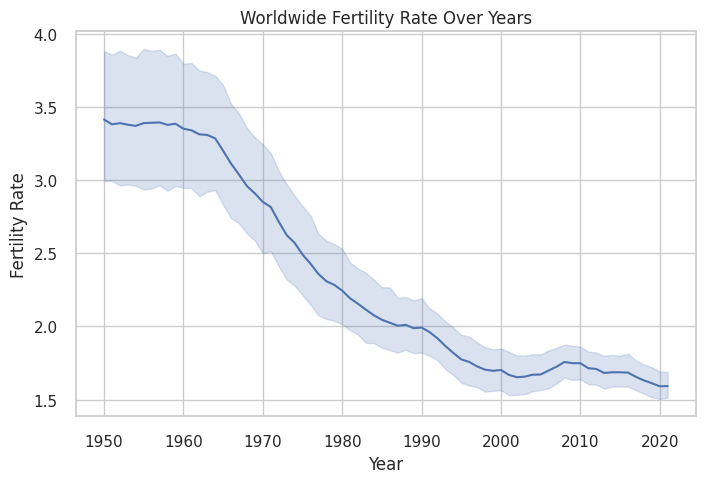

In [ ]:
# Set Figure Size
plt.figure(figsize = (8, 5))
sns.set(style = "whitegrid")

# Fertility Rate Worldwide
sns.lineplot(x = 'year', y = 'fertility_rate', data = df_fertility)
plt.xlabel("Year")
plt.ylabel("Fertility Rate")
plt.title("Worldwide Fertility Rate Over Years")
plt.legend([], [], frameon = False)
plt.show()

In [ ]:
# Filter to South Korea's Fertility Rates
df_fertility_kr = df_fertility[df_fertility['country'] == 'Republic of Korea']
df_fertility_kr = df_fertility_kr[["year", "fertility_rate"]]
df_fertility_kr = df_fertility_kr.rename(columns = {'fertility_rate': 'korea_fertility_rate'})

In [ ]:
# Dataframe for Fertility Rate Worldwide vs. Korea
df_fertility_global = df_fertility[["year", "fertility_rate"]]
df_fertility_global = df_fertility_global.groupby("year").mean().reset_index()
df_fertility_global = df_fertility_global.rename(columns = {'fertility_rate': 'global_fertility_rate'})

# Merge Dataframe
df_fertility_global = pd.merge(df_fertility_global, df_fertility_kr, on = "year")

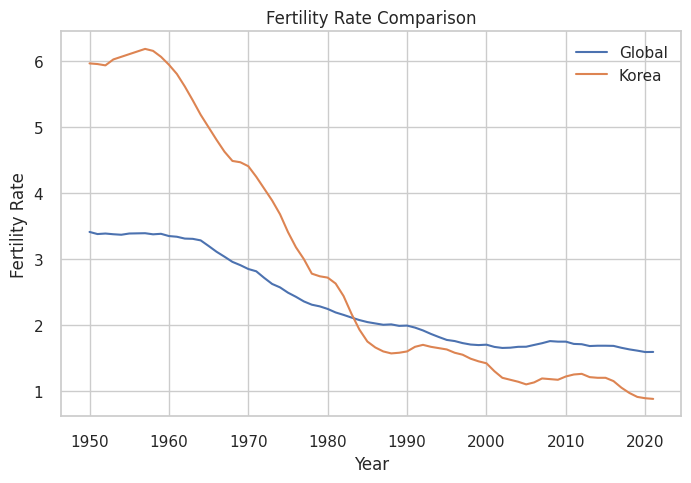

In [ ]:
# Fertility Rate Comparison between OECD Countries vs. Korea
df_fertility_global.plot(x = "year", y = ["global_fertility_rate", "korea_fertility_rate"],
        kind = "line", figsize = (8, 5))

# Edit Labels
plt.xlabel("Year")
plt.ylabel("Fertility Rate")
plt.title("Fertility Rate Comparison")
plt.legend(labels = ('Global', 'Korea'))
plt.show()

Afterward, we conducted a comparison between the global fertility rate trend and that of South Korea. The graph shows that in 1950, South Korea's fertility rate was almost twice as high as the worldwide average, with an average fertility rate of 6 compared to the global average of 3.5. However, the fertility rate in South Korea experienced a significant decrease from 1950 to 1990, reaching a rate of 1.5. Currently, the fertility rate in South Korea is less than 1, which is significantly lower than the global average of between 1 and 2.

##### Correlation Matrix

We calculated a correlation matrix to explore the interdependence among several variables.

In [ ]:
# Re-indexing dataframe for better visualization of correlation matrix.
df_merged_viz = df_merged.reindex(columns=['labour_participation_rate', 'birth_rate',
       'mean_age_bearing', 'housing_value', 'total_deaths',
       'death_rate', 'life_expectancy', 'total_pop', 'male_pop', 'female_pop',
       'pop_density', 'median_age', 'pop_growth_rate', 'gender_wage_gap_perc',
       'average_wage_rate', 'internet_access_perc', 'education_rate',
       'crude_marriage_rate', 'crude_divorce_rate', 'suicide_rate', 'fertility_rate'])


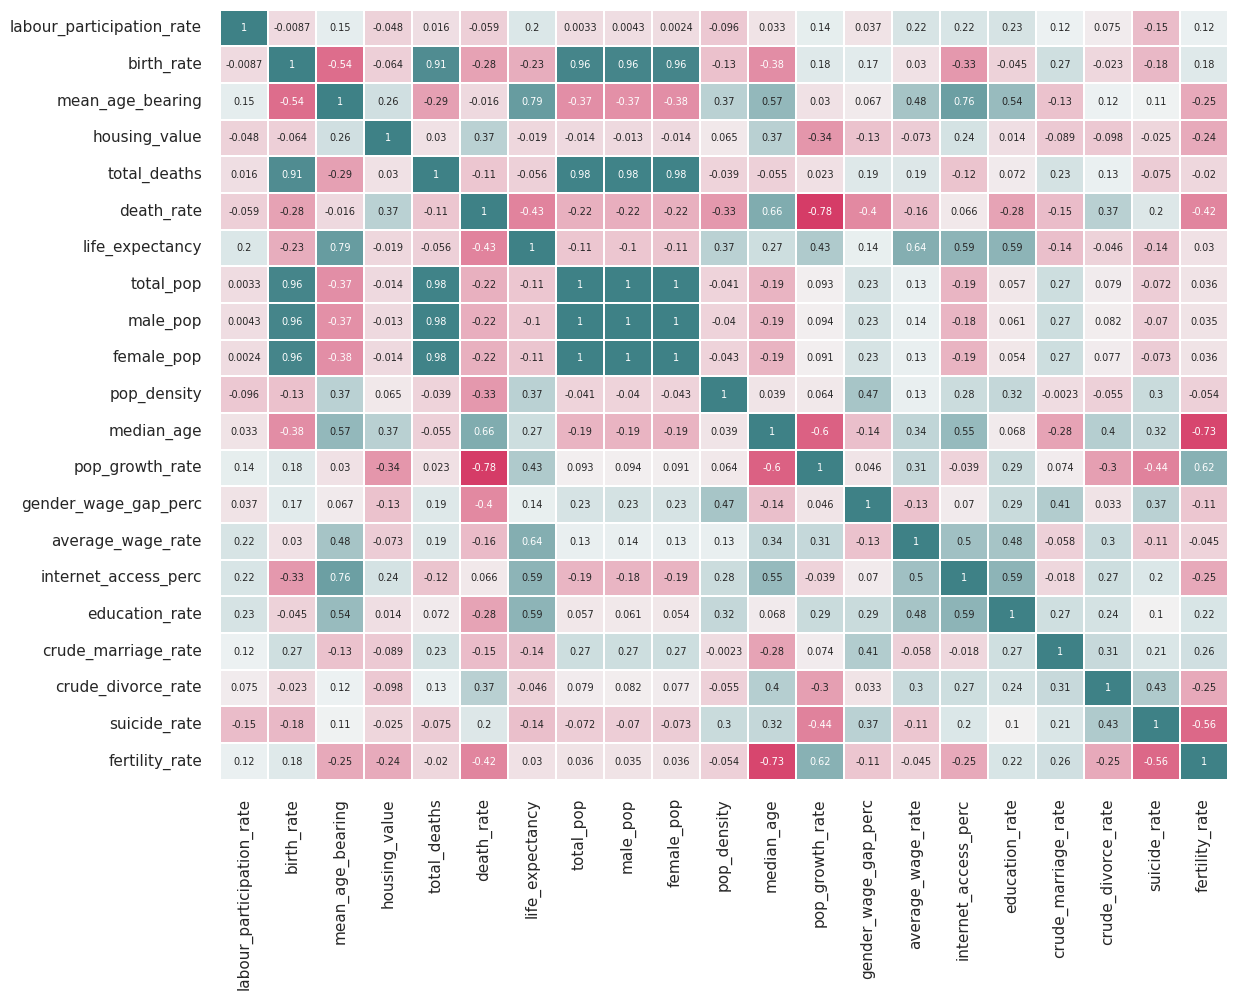

In [ ]:
# Set Figure Size
plt.figure(figsize = (13, 10))

# Plot the Correlation Matrix
cmap = sns.diverging_palette(1, 200, as_cmap = True)
sns.heatmap(df_merged_viz.corr(), cmap = cmap, annot = True, annot_kws = {"size": 7}, linewidths = 0.1, cbar = False)
plt.show()

### Divide into Categories

In [ ]:
# Check the columns in the dataset.
df_merged.columns

Index(['country', 'year', 'labour_participation_rate', 'birth_rate',
       'fertility_rate', 'mean_age_bearing', 'housing_value', 'total_deaths',
       'death_rate', 'life_expectancy', 'total_pop', 'male_pop', 'female_pop',
       'pop_density', 'median_age', 'pop_growth_rate', 'gender_wage_gap_perc',
       'average_wage_rate', 'internet_access_perc', 'education_rate',
       'crude_marriage_rate', 'crude_divorce_rate', 'suicide_rate', 'time'],
      dtype='object')

We check the columns and divide it into X(input variables) and y(target variables) for Random Forest and Lasso model. We have excluded columns of **"country", "year," "birth_rate", "total_deaths", "male_pop", "female_pop", "median_age", "pop_growth_rate", and "time"**, due to either being too informative, or being irrelevant or redundant features.

In [ ]:
X = df_merged[['labour_participation_rate', 'housing_value', 'average_wage_rate', 'gender_wage_gap_perc', 'internet_access_perc', 'education_rate',
            'mean_age_bearing', 'life_expectancy', 'pop_density', 'crude_marriage_rate', 'crude_divorce_rate', 'suicide_rate']]
y = df_merged['fertility_rate']

In [ ]:
# Change Data Type
X = X.astype(float)

## Random Forest Regression

We utilized a random forest regression to determine the variable that has the highest correlation or impact on the fertility rate. Below, the function is used to plot the feature importance of a machine learning model. It takes three arguments as input:


*   importance: A list of numeric values representing the importance of each feature.
*   name: A list of strings representing the names of the features.
*   model_type: A string representing the type of the machine learning model.

Overall, this function can be used to visualize the relative importance of each feature in a machine learning model.

In [ ]:
# Function to Plot Feature Importance
def feature_importance_func(importance, name, model_type):

  # Create Arrays from Feature Importance and Names
  feature_importance = np.array(importance)
  feature_names = np.array(name)

  # Create Dataframe using a Dictionary
  data = {'feature_names': feature_names, 'feature_importance': feature_importance}
  fi_df = pd.DataFrame(data)

  # Sort in Descending Order of Feature Importance
  fi_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)

  # Set Figure Size
  plt.figure(figsize = (6, 4))

  # Plot Bar Chart
  sns.set(style = "whitegrid")
  sns.barplot(x = fi_df['feature_importance'], y = fi_df['feature_names'], palette = "rocket")

  # Add Labels
  plt.title(model_type + ' FEATURE IMPORTANCE', fontsize = 10)
  plt.xlabel('FEATURE IMPORTANCE', fontsize = 7)
  plt.ylabel('FEATURE NAMES', fontsize = 7)

##### Train and Test Split

In [ ]:
# Set the trees to be 500
m = RandomForestRegressor(n_estimators = 500)
_ = m.fit(X, y)
m.score(X, y)
# Split the dataset into 30% of test data, and 70% of random data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train.shape

(896, 12)

##### Prediction

In [ ]:
# Predict
m.fit(X_train, y_train)
preds = m.predict(X_test)

print(m.score(X_train, y_train))
print(m.score(X_test, y_test))

0.9994299377048749
0.995886178537155


##### Feature Importance

In [ ]:
m.feature_importances_

array([2.79825647e-04, 4.86990854e-02, 2.10959073e-02, 2.22776306e-02,
       1.74693199e-02, 1.51873511e-01, 6.37825483e-02, 2.80043355e-02,
       8.54586536e-02, 9.90822851e-02, 1.83474395e-02, 4.43629458e-01])

##### Data Visualization

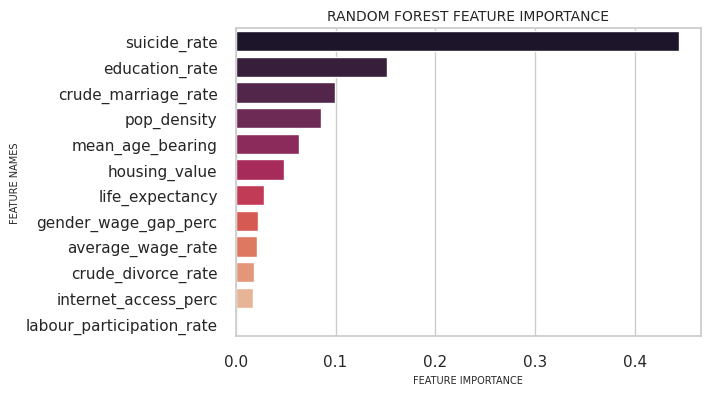

In [ ]:
feature_importance_func(m.feature_importances_, X_train.columns, 'RANDOM FOREST')

The Random Forest feature importance chart shows us which variables tend to be selected by our trees the most. From this chart we can see the overwhelming importance of suicide_rate in determining fertility rates. It is possible that it is because suicide rates hold a lot of information about the quality of living of sad country.

## LASSO Regression

##### Set Pipeline

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), ('model', Lasso())])

##### Finding the Optimal Alpha Values

In [ ]:
# Use GridSearchCV to find the optimal alpha values through calculating the average value of the
# Mean squared error in a 5-folds cross-validation and selecing the value of alpha that minimizes
# Average performance metrics. The test values are from -0.1 to 1 with 0.01 steps.
search = GridSearchCV(pipeline, {'model__alpha': np.arange(-0.1,0.1,0.01)},
                      cv = 5, scoring = "neg_mean_squared_error", verbose = 3)
search.fit(X_train, y_train)
search.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...................model__alpha=-0.1;, score=nan total time=   0.0s
[CV 2/5] END ...................model__alpha=-0.1;, score=nan total time=   0.0s
[CV 3/5] END ...................model__alpha=-0.1;, score=nan total time=   0.0s
[CV 4/5] END ...................model__alpha=-0.1;, score=nan total time=   0.0s
[CV 5/5] END ...................model__alpha=-0.1;, score=nan total time=   0.0s
[CV 1/5] END ...model__alpha=-0.09000000000000001;, score=nan total time=   0.0s
[CV 2/5] END ...model__alpha=-0.09000000000000001;, score=nan total time=   0.0s
[CV 3/5] END ...model__alpha=-0.09000000000000001;, score=nan total time=   0.0s
[CV 4/5] END ...model__alpha=-0.09000000000000001;, score=nan total time=   0.0s
[CV 5/5] END ...model__alpha=-0.09000000000000001;, score=nan total time=   0.0s
[CV 1/5] END ...model__alpha=-0.08000000000000002;, score=nan total time=   0.0s
[CV 2/5] END ...model__alpha=-0.080000000000000

{'model__alpha': 0.00999999999999994}

In [ ]:
# Get the coefficient of the Lasso Regression
coefficients = search.best_estimator_.named_steps['model'].coef_

##### Feature Importance

In [ ]:
# Calculate the Absolute Value of its Coefficient
importance = np.abs(coefficients)
print(importance)

[0.00629083 0.09286402 0.06727716 0.09873206 0.03015518 0.19148406
 0.09620367 0.         0.07090972 0.12170487 0.03867557 0.2331127 ]


In [ ]:
X_train.columns[importance != 0]

Index(['labour_participation_rate', 'housing_value', 'average_wage_rate',
       'gender_wage_gap_perc', 'internet_access_perc', 'education_rate',
       'mean_age_bearing', 'pop_density', 'crude_marriage_rate',
       'crude_divorce_rate', 'suicide_rate'],
      dtype='object')

Our Lasso model, only removed one variable in the model which was life expectancy. All other variables do not seem to be that highly correlated, which is why we did not put that much attention to our LASSO estimates for variable selection.

##### Data Visualization

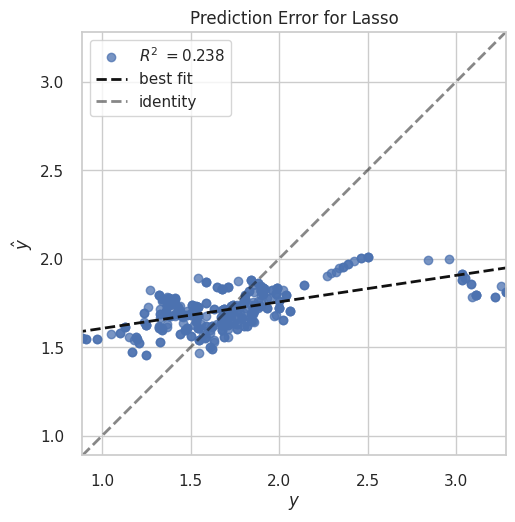

<Axes: title={'center': 'Prediction Error for Lasso'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [ ]:
# Prediction Error
lasso_plot_1 = Lasso()
visualizer = PredictionError(lasso_plot_1)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

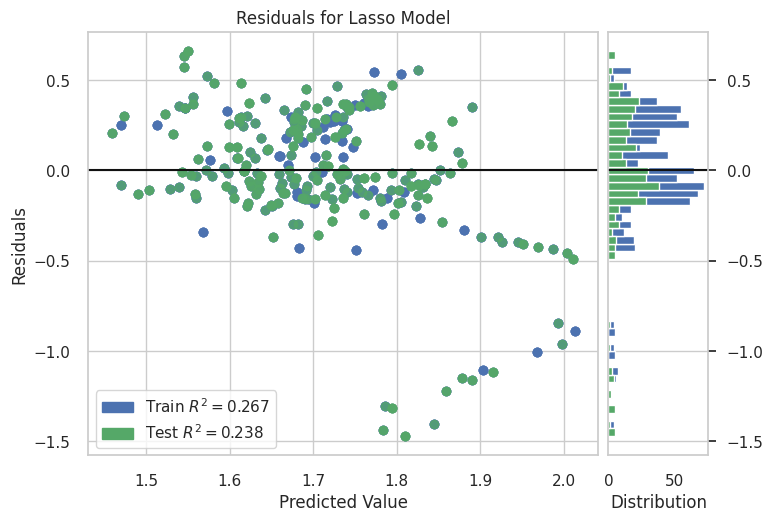

<Axes: title={'center': 'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [ ]:
# Residuals Plot
lasso_plot_2 = Lasso()
visualizer = ResidualsPlot(lasso_plot_2)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

## Linear Mixed Effects Model

In [ ]:
md = smf.mixedlm("fertility_rate ~ education_rate + gender_wage_gap_perc + crude_divorce_rate + pop_density + suicide_rate",
                 data = df_merged, groups = df_merged["country"], re_formula = "~time")
mdf = md.fit()
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  fertility_rate
No. Observations:  1280     Method:              REML          
No. Groups:        31       Scale:               0.0026        
Min. group size:   10       Log-Likelihood:      1793.7325     
Max. group size:   80       Converged:           Yes           
Mean group size:   41.3                                        
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             1.951    0.125 15.665 0.000  1.707  2.195
education_rate       -0.005    0.002 -2.531 0.011 -0.009 -0.001
gender_wage_gap_perc -0.005    0.001 -4.353 0.000 -0.007 -0.003
crude_divorce_rate   -0.022    0.012 -1.842 0.065 -0.045  0.001
pop_density           0.000    0.000  0.150 0.881 -0.001  0.001
suicide_rate          0.001    0.002  0.340 0.734 -0.

$$
\begin{aligned}
\text{Fertility Rate} &= X\beta + Zb \\
X &= \text{Education Rate, Crude Divorce Rate, Population Density, Suicide Rate, Gender Wage Gap Percentage}\\
Z &= \text{Country, Time}
\end{aligned}
$$

The results of our LMM model shows that the most significant variable is the `gender_wage_gap_perc` gender wage gap percentage which tells us the higher the gender wage gap between male and female the lower the fertility.

Although suicide rate coefficient shows that the higher the suicide rate the higher the fertility rate, but this is after considering all the other variables in the model which are multicollinear with each other. Because we have multicollinearity between the variables of this model we cant really trust the coefficient values of this model.

In [ ]:
random_effects = mdf.random_effects
print(random_effects)

{'Australia': Group    0.330123
time    -0.011953
dtype: float64, 'Austria': Group   -0.286917
time     0.006082
dtype: float64, 'Belgium': Group    0.144577
time    -0.015548
dtype: float64, 'Canada': Group   -0.012272
time     0.038830
dtype: float64, 'Czechia': Group   -0.393255
time     0.025326
dtype: float64, 'Denmark': Group    0.151995
time    -0.009899
dtype: float64, 'Estonia': Group    0.004845
time     0.004100
dtype: float64, 'France': Group    0.235981
time     0.005359
dtype: float64, 'Germany': Group   -0.394698
time     0.017211
dtype: float64, 'Greece': Group   -0.307229
time    -0.015127
dtype: float64, 'Hungary': Group   -0.614474
time     0.029739
dtype: float64, 'Iceland': Group    0.410666
time     0.017400
dtype: float64, 'Ireland': Group    0.271738
time    -0.000878
dtype: float64, 'Israel': Group    1.243149
time     0.028624
dtype: float64, 'Italy': Group   -0.443111
time     0.000376
dtype: float64, 'Japan': Group   -0.296081
time     0.021699
dtype: float6

In [ ]:
ranked_group = sorted(random_effects.items(), key = lambda x: x[1]['Group'], reverse = True)

In [ ]:
ranked_group

[('Israel',
  Group    1.243149
  time     0.028624
  dtype: float64),
 ('Mexico',
  Group    0.710554
  time    -0.034991
  dtype: float64),
 ('United States of America',
  Group    0.528808
  time    -0.029519
  dtype: float64),
 ('Iceland',
  Group    0.410666
  time     0.017400
  dtype: float64),
 ('United Kingdom',
  Group    0.335328
  time    -0.018506
  dtype: float64),
 ('Australia',
  Group    0.330123
  time    -0.011953
  dtype: float64),
 ('Ireland',
  Group    0.271738
  time    -0.000878
  dtype: float64),
 ('Norway',
  Group    0.255964
  time    -0.015900
  dtype: float64),
 ('France',
  Group    0.235981
  time     0.005359
  dtype: float64),
 ('Sweden',
  Group    0.187274
  time     0.000241
  dtype: float64),
 ('Denmark',
  Group    0.151995
  time    -0.009899
  dtype: float64),
 ('Belgium',
  Group    0.144577
  time    -0.015548
  dtype: float64),
 ('Netherlands',
  Group    0.070564
  time    -0.011073
  dtype: float64),
 ('Estonia',
  Group    0.004845
  time

In [ ]:
ranked_time = sorted(random_effects.items(), key = lambda x: x[1]['time'], reverse = True)

In [ ]:
ranked_time

[('Canada',
  Group   -0.012272
  time     0.038830
  dtype: float64),
 ('Hungary',
  Group   -0.614474
  time     0.029739
  dtype: float64),
 ('Israel',
  Group    1.243149
  time     0.028624
  dtype: float64),
 ('Czechia',
  Group   -0.393255
  time     0.025326
  dtype: float64),
 ('Lithuania',
  Group   -0.324103
  time     0.023932
  dtype: float64),
 ('Latvia',
  Group   -0.329683
  time     0.023390
  dtype: float64),
 ('Japan',
  Group   -0.296081
  time     0.021699
  dtype: float64),
 ('Iceland',
  Group    0.410666
  time     0.017400
  dtype: float64),
 ('Germany',
  Group   -0.394698
  time     0.017211
  dtype: float64),
 ('Poland',
  Group   -0.490243
  time     0.015084
  dtype: float64),
 ('Slovenia',
  Group   -0.314498
  time     0.014035
  dtype: float64),
 ('Switzerland',
  Group   -0.208931
  time     0.012559
  dtype: float64),
 ('Austria',
  Group   -0.286917
  time     0.006082
  dtype: float64),
 ('France',
  Group    0.235981
  time     0.005359
  dtype: fl

In [ ]:
cov_re = mdf.cov_re
print(cov_re)

          Group      time
Group  0.176663 -0.002623
time  -0.002623  0.000361


### Linear Regression

##### Data Visualization

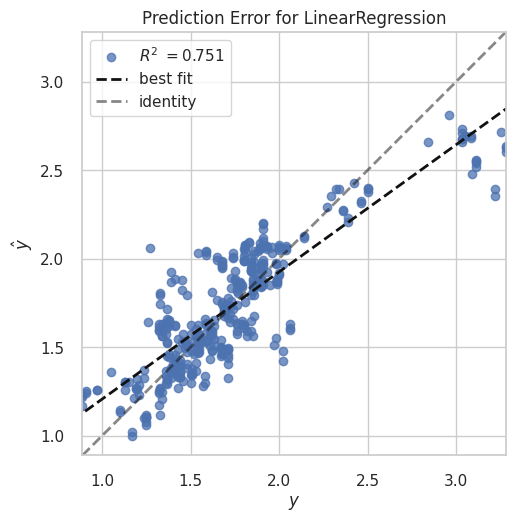

<Axes: title={'center': 'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [ ]:
# Prediction Error
lr_plot_1 = LinearRegression()
visualizer = PredictionError(lr_plot_1)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

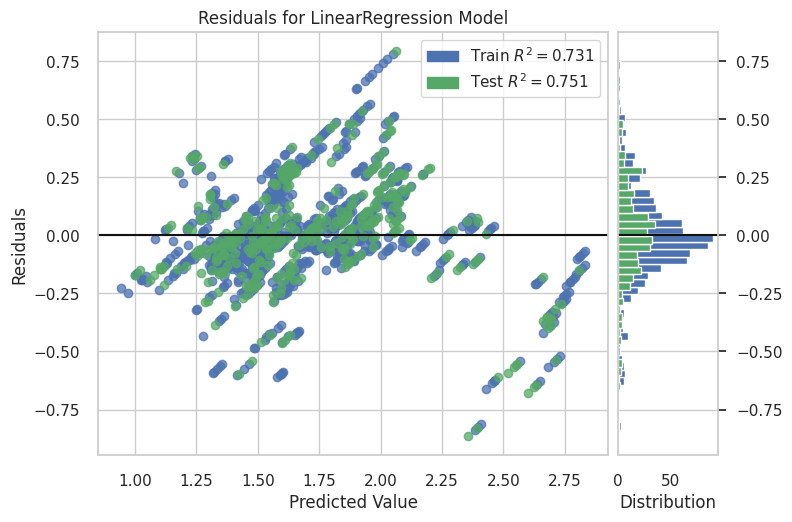

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [ ]:
# Residuals Plot
visualizer = ResidualsPlot(lr_plot_1)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [ ]:
# Assign residual values
residuals = mdf.resid

Text(0.5, 1.0, 'Histogram of Residuals')

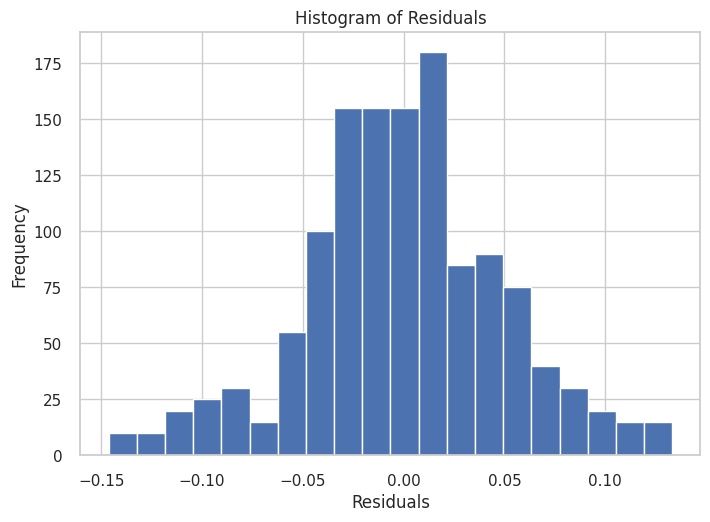

In [ ]:
# Draw Histogram of Residuals
fig, ax = plt.subplots()
ax.hist(residuals, bins = 20)
ax.set_xlabel("Residuals")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Residuals")

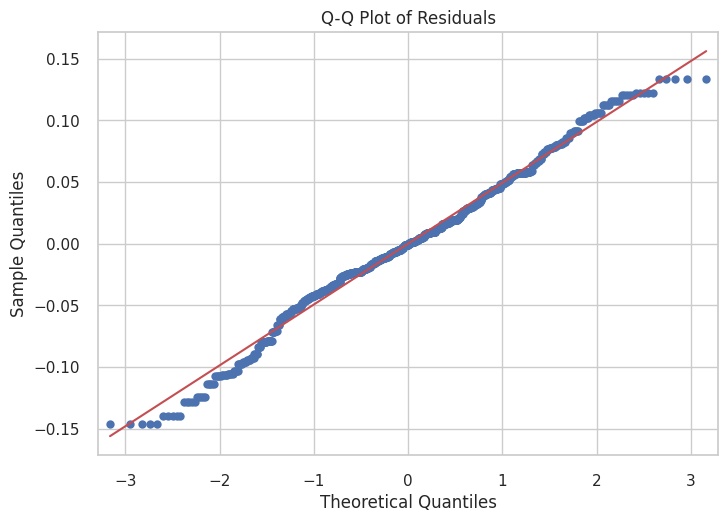

In [ ]:
# Draw Q-Q plot of Residuals
fig, ax = plt.subplots()
sm.qqplot(residuals, line = 's', ax = ax)
ax.set_title("Q-Q Plot of Residuals")
plt.show()

## Research about Suicide Rate

Studies show that suicide rate is highly related to economic constraints such as unemployment, but there are other employment factors that cannot be quantified for such as stress in the workplace. We believe that suicide rate can be potentially used as an instrument that captures the overall happiness/quality of life of said country (Kim, 2020).

## References

*   Jeong, K., Yoon, J., Cho, H. J., Kim, S., & Jang, J. (2022). The Relationship Between Changes In The Korean Fertility Rate And Policies To  Encourage Fertility. BMC Public Health, 22(1), 2298. https://doi.org/10.1186/s12889-022-14722-4
*   Kim, A. M. (2020). Factors Associated With The Suicide Rates In Korea. Psychiatry Research, 284(112745), 112745.
https://doi.org/10.1016/j.psychres.2020.112745
*   OECD (2023), "Family Indicators", OECD Social and Welfare Statistics (database), https://doi.org/10.1787/efd30a09-en (accessed on 12 April 2023).
*   OECD (2023), Fertility rates (indicator). doi: 10.1787/8272fb01-en (Accessed on 11 April 2023)
*   OECD (2023), Housing prices (indicator). doi: 10.1787/63008438-en (Accessed on 11 April 2023)
*   OECD (2023), Internet access (indicator). doi: 10.1787/69c2b997-en (Accessed on 11 April 2023)
*   OECD (2023), Spending on tertiary education (indicator). doi: 10.1787/a3523185-en (Accessed on 11 April 2023)
*   OECD (2023), Suicide rates (indicator). doi: 10.1787/a82f3459-en (Accessed on 11 April 2023)
*   United Nations, Department of Economic and Social Affairs, Population Division (2022). World Population Prospects 2022, Online Edition.
*   Yun, J., Kim, C. Y., Son, S. H., Bae, C. W., Choi, Y. S., & Chung, S. H. (2022). Birth Rate Transition in the Republic of Korea: Trends and Prospects. Journal of Korean medical science, 37(42), e304. https://doi.org/10.3346/jkms.2022.37.e304


